A branch was pruned: gain = 0.146094
PetalLength >= 3?
yes -> PetalWidth >= 1.8?
		yes -> PetalLength >= 4.9?
				yes -> virginica: 43
				no  -> SepalLength >= 6?
						yes -> virginica: 2
						no  -> versicolor: 1
		no  -> PetalLength >= 5?
				yes -> PetalWidth >= 1.6?
						yes -> SepalLength >= 7.2?
								yes -> virginica: 1
								no  -> versicolor: 2
						no  -> virginica: 3
				no  -> versicolor: 47, virginica: 1
no  -> setosa: 50
{'virginica': 3}
{'virginica': 0.5315890699277861, 'versicolor': 21.039735820299743, 'setosa': 26.218383713756943}


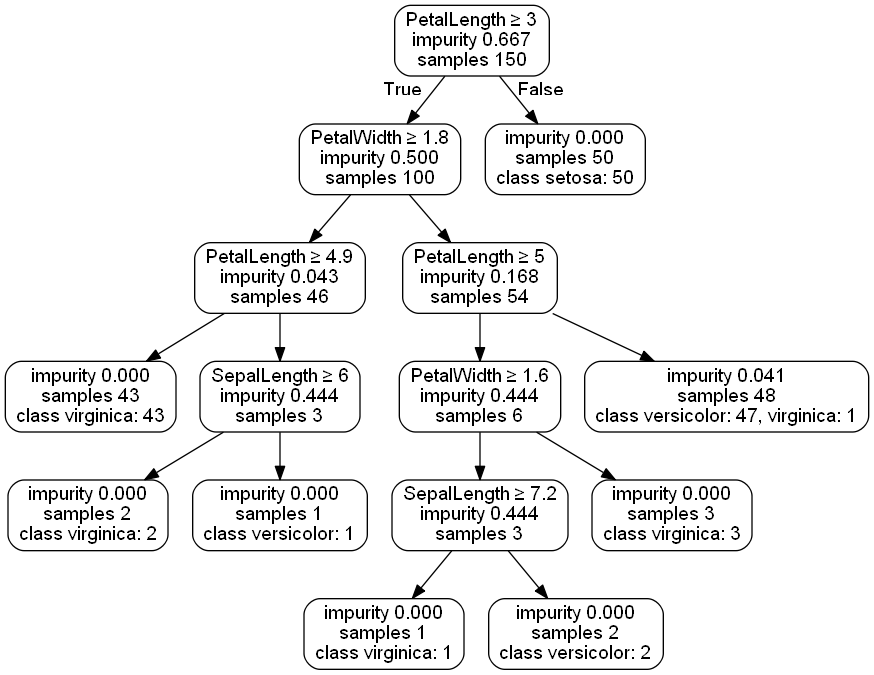

In [5]:
import csv
from collections import defaultdict
import pydotplus

from IPython.display import Image,display

class DecisionTree:
    """Binary tree implementation with true and false branch. """

    def __init__(self, col=-1, value=None, trueBranch=None, falseBranch=None, results=None, summary=None):
        self.col = col
        self.value = value
        self.trueBranch = trueBranch
        self.falseBranch = falseBranch
        self.results = results  # None for nodes, not None for leaves
        self.summary = summary


def divideSet(rows, column, value):
    splittingFunction = None
    if isinstance(value, int) or isinstance(value, float):  # for int and float values
        splittingFunction = lambda row: row[column] >= value
    else:  # for strings
        splittingFunction = lambda row: row[column] == value
    list1 = [row for row in rows if splittingFunction(row)]
    list2 = [row for row in rows if not splittingFunction(row)]
    return (list1, list2)


def uniqueCounts(rows):
    results = {}
    for row in rows:
        # response variable is in the last column
        r = row[-1]
        if r not in results: results[r] = 0
        results[r] += 1
    return results


def entropy(rows):
    from math import log
    log2 = lambda x: log(x) / log(2)
    results = uniqueCounts(rows)

    entr = 0.0
    for r in results:
        p = float(results[r]) / len(rows)
        entr -= p * log2(p)
    return entr


def gini(rows):
    total = len(rows)
    counts = uniqueCounts(rows)
    imp = 0.0

    for k1 in counts:
        p1 = float(counts[k1]) / total
        for k2 in counts:
            if k1 == k2: continue
            p2 = float(counts[k2]) / total
            imp += p1 * p2
    return imp


def variance(rows):
    if len(rows) == 0: return 0
    data = [float(row[len(row) - 1]) for row in rows]
    mean = sum(data) / len(data)

    variance = sum([(d - mean) ** 2 for d in data]) / len(data)
    return variance


def growDecisionTreeFrom(rows, evaluationFunction=entropy):
    """Grows and then returns a binary decision tree.
    evaluationFunction: entropy or gini"""

    if len(rows) == 0: return DecisionTree()
    currentScore = evaluationFunction(rows)

    bestGain = 0.0
    bestAttribute = None
    bestSets = None

    columnCount = len(rows[0]) - 1  # last column is the result/target column
    for col in range(0, columnCount):
        columnValues = [row[col] for row in rows]

        # unique values
        lsUnique = list(set(columnValues))

        for value in lsUnique:
            (set1, set2) = divideSet(rows, col, value)

            # Gain -- Entropy or Gini
            p = float(len(set1)) / len(rows)
            gain = currentScore - p * evaluationFunction(set1) - (1 - p) * evaluationFunction(set2)
            if gain > bestGain and len(set1) > 0 and len(set2) > 0:
                bestGain = gain
                bestAttribute = (col, value)
                bestSets = (set1, set2)

    dcY = {'impurity': '%.3f' % currentScore, 'samples': '%d' % len(rows)}
    if bestGain > 0:
        trueBranch = growDecisionTreeFrom(bestSets[0], evaluationFunction)
        falseBranch = growDecisionTreeFrom(bestSets[1], evaluationFunction)
        return DecisionTree(col=bestAttribute[0], value=bestAttribute[1], trueBranch=trueBranch,
                            falseBranch=falseBranch, summary=dcY)
    else:
        return DecisionTree(results=uniqueCounts(rows), summary=dcY)


def prune(tree, minGain, evaluationFunction=entropy, notify=False):
    """Prunes the obtained tree according to the minimal gain (entropy or Gini). """
    # recursive call for each branch
    if tree.trueBranch.results is None: prune(tree.trueBranch, minGain, evaluationFunction, notify)
    if tree.falseBranch.results is None: prune(tree.falseBranch, minGain, evaluationFunction, notify)

    # merge leaves (potentionally)
    if tree.trueBranch.results is not None and tree.falseBranch.results is not None:
        tb, fb = [], []

        for v, c in tree.trueBranch.results.items(): tb += [[v]] * c
        for v, c in tree.falseBranch.results.items(): fb += [[v]] * c

        p = float(len(tb)) / len(tb + fb)
        delta = evaluationFunction(tb + fb) - p * evaluationFunction(tb) - (1 - p) * evaluationFunction(fb)
        if delta < minGain:
            if notify: print('A branch was pruned: gain = %f' % delta)
            tree.trueBranch, tree.falseBranch = None, None
            tree.results = uniqueCounts(tb + fb)


def classify(observations, tree, dataMissing=False):
    """Classifies the observationss according to the tree.
    dataMissing: true or false if data are missing or not. """

    def classifyWithoutMissingData(observations, tree):
        if tree.results is not None:  # leaf
            return tree.results
        else:
            v = observations[tree.col]
            branch = None
            if isinstance(v, int) or isinstance(v, float):
                if v >= tree.value:
                    branch = tree.trueBranch
                else:
                    branch = tree.falseBranch
            else:
                if v == tree.value:
                    branch = tree.trueBranch
                else:
                    branch = tree.falseBranch
        return classifyWithoutMissingData(observations, branch)

    def classifyWithMissingData(observations, tree):
        if tree.results is not None:  # leaf
            return tree.results
        else:
            v = observations[tree.col]
            if v is None:
                tr = classifyWithMissingData(observations, tree.trueBranch)
                fr = classifyWithMissingData(observations, tree.falseBranch)
                tcount = sum(tr.values())
                fcount = sum(fr.values())
                tw = float(tcount) / (tcount + fcount)
                fw = float(fcount) / (tcount + fcount)
                result = defaultdict(int)  # Problem description: http://blog.ludovf.net/python-collections-defaultdict/
                for k, v in tr.items(): result[k] += v * tw
                for k, v in fr.items(): result[k] += v * fw
                return dict(result)
            else:
                branch = None
                if isinstance(v, int) or isinstance(v, float):
                    if v >= tree.value:
                        branch = tree.trueBranch
                    else:
                        branch = tree.falseBranch
                else:
                    if v == tree.value:
                        branch = tree.trueBranch
                    else:
                        branch = tree.falseBranch
            return classifyWithMissingData(observations, branch)

    # function body
    if dataMissing:
        return classifyWithMissingData(observations, tree)
    else:
        return classifyWithoutMissingData(observations, tree)


def plot(decisionTree):
    """Plots the obtained decision tree. """

    def toString(decisionTree, indent=''):
        if decisionTree.results is not None:  # leaf node
            lsX = [(x, y) for x, y in decisionTree.results.items()]
            lsX.sort()
            szY = ', '.join(['%s: %s' % (x, y) for x, y in lsX])
            return szY
        else:
            szCol = 'Column %s' % decisionTree.col
            if szCol in dcHeadings:
                szCol = dcHeadings[szCol]
            if isinstance(decisionTree.value, int) or isinstance(decisionTree.value, float):
                decision = '%s >= %s?' % (szCol, decisionTree.value)
            else:
                decision = '%s == %s?' % (szCol, decisionTree.value)
            trueBranch = indent + 'yes -> ' + toString(decisionTree.trueBranch, indent + '\t\t')
            falseBranch = indent + 'no  -> ' + toString(decisionTree.falseBranch, indent + '\t\t')
            return decision + '\n' + trueBranch + '\n' + falseBranch

    print(toString(decisionTree))


def dotgraph(decisionTree):
    global dcHeadings
    dcNodes = defaultdict(list)
    """Plots the obtained decision tree. """

    def toString(iSplit, decisionTree, bBranch, szParent="null", indent=''):
        if decisionTree.results is not None:  # leaf node
            lsX = [(x, y) for x, y in decisionTree.results.items()]
            lsX.sort()
            szY = ', '.join(['%s: %s' % (x, y) for x, y in lsX])
            dcY = {"name": szY, "parent": szParent}
            dcSummary = decisionTree.summary
            dcNodes[iSplit].append(['leaf', dcY['name'], szParent, bBranch, dcSummary['impurity'],
                                    dcSummary['samples']])
            return dcY
        else:
            szCol = 'Column %s' % decisionTree.col
            if szCol in dcHeadings:
                szCol = dcHeadings[szCol]
            if isinstance(decisionTree.value, int) or isinstance(decisionTree.value, float):
                decision = '%s >= %s' % (szCol, decisionTree.value)
            else:
                decision = '%s == %s' % (szCol, decisionTree.value)
            trueBranch = toString(iSplit + 1, decisionTree.trueBranch, True, decision, indent + '\t\t')
            falseBranch = toString(iSplit + 1, decisionTree.falseBranch, False, decision, indent + '\t\t')
            dcSummary = decisionTree.summary
            dcNodes[iSplit].append([iSplit + 1, decision, szParent, bBranch, dcSummary['impurity'],
                                    dcSummary['samples']])
            return

    toString(0, decisionTree, None)
    lsDot = ['digraph Tree {',
             'node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;',
             'edge [fontname=helvetica] ;'
             ]
    i_node = 0
    dcParent = {}
    for nSplit in range(len(dcNodes)):
        lsY = dcNodes[nSplit]
        for lsX in lsY:
            iSplit, decision, szParent, bBranch, szImpurity, szSamples = lsX
            if type(iSplit) == int:
                szSplit = '%d-%s' % (iSplit, decision)
                dcParent[szSplit] = i_node
                lsDot.append('%d [label=<%s<br/>impurity %s<br/>samples %s>, fillcolor="#e5813900"] ;' % (i_node,
                                                                                                          decision.replace(
                                                                                                              '>=',
                                                                                                              '&ge;').replace(
                                                                                                              '?', ''),
                                                                                                          szImpurity,
                                                                                                          szSamples))
            else:
                lsDot.append('%d [label=<impurity %s<br/>samples %s<br/>class %s>, fillcolor="#e5813900"] ;' % (i_node,
                                                                                                                szImpurity,
                                                                                                                szSamples,
                                                                                                                decision))

            if szParent != 'null':
                if bBranch:
                    szAngle = '45'
                    szHeadLabel = 'True'
                else:
                    szAngle = '-45'
                    szHeadLabel = 'False'
                szSplit = '%d-%s' % (nSplit, szParent)
                p_node = dcParent[szSplit]
                if nSplit == 1:
                    lsDot.append('%d -> %d [labeldistance=2.5, labelangle=%s, headlabel="%s"] ;' % (p_node,
                                                                                                    i_node, szAngle,
                                                                                                    szHeadLabel))
                else:
                    lsDot.append('%d -> %d ;' % (p_node, i_node))
            i_node += 1
    lsDot.append('}')
    dot_data = '\n'.join(lsDot)
    return dot_data


def loadCSV(file):
    """Loads a CSV file and converts all floats and ints into basic datatypes."""

    def convertTypes(s):
        s = s.strip()
        try:
            return float(s) if '.' in s else int(s)
        except ValueError:
            return s

    reader = csv.reader(open(file, 'rt'))
    dcHeader = {}
    if bHeader:
        lsHeader = next(reader)
        for i, szY in enumerate(lsHeader):
            szCol = 'Column %d' % i
            dcHeader[szCol] = str(szY)
    return dcHeader, [[convertTypes(item) for item in row] for row in reader]


if __name__ == '__main__':

    # Select the example you want to classify
    example = 2

    # All examples do the following steps:
    #   1. Load training data
    #   2. Let the decision tree grow
    #   4. Plot the decision tree
    #   5. classify without missing data
    #   6. Classifiy with missing data
    #   (7.) Prune the decision tree according to a minimal gain level
    #   (8.) Plot the pruned tree

    if example == 1:
        # the smaller examples
        bHeader = False
        dcHeadings, trainingData = loadCSV('tbc.csv')  # sorry for not translating the TBC and pneumonia symptoms
        decisionTree = growDecisionTreeFrom(trainingData)
        # decisionTree = growDecisionTreeFrom(trainingData, evaluationFunction=gini) # with gini
        result = plot(decisionTree)
        # print(result)
        dot_data = dotgraph(decisionTree)
        graph = pydotplus.graph_from_dot_data(dot_data)
        graph.write_pdf("tbc.pdf")
        graph.write_png("tbc.png")
        display(Image(filename='tbc.png'))


        print(classify(['ohne', 'leicht', 'Streifen', 'normal', 'normal'], decisionTree, dataMissing=False))
        print(classify([None, 'leicht', None, 'Flocken', 'fiepend'], decisionTree, dataMissing=True))  # no longer unique

        # Don' forget if you compare the resulting tree with the tree in my presentation: here it is a binary tree!

    else:
        bHeader = True
        # the bigger example
        dcHeadings, trainingData = loadCSV('fishiris.csv')  # demo data from matlab
        decisionTree = growDecisionTreeFrom(trainingData, evaluationFunction=gini)
        prune(decisionTree, 0.8, notify=True)  # notify, when a branch is pruned (one time in this example)
        result = plot(decisionTree)
        # print(result)
        dot_data = dotgraph(decisionTree)
        graph = pydotplus.graph_from_dot_data(dot_data)
        graph.write_pdf("iris.pdf")
        graph.write_png("iris.png")
        display(Image(filename='iris.png'))

        print(classify([6.0, 2.2, 5.0, 1.5], decisionTree))  # dataMissing=False is the default setting
        print(classify([None, None, None, 1.5], decisionTree, dataMissing=True))  # no longer unique

